In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)


train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(validation_dataset)} samples")
print(f"Test Set: {len(testset)} samples")

Training Set: 48000 samples
Validation Set: 12000 samples
Test Set: 10000 samples


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchsummary import summary

class LeNet5Modified(nn.Module):
    def __init__(self):
        super(LeNet5Modified, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Initialize weights using kaiming_uniform_
        self._initialize_weights()

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


model = LeNet5Modified()

# # Cross entropy
# criterion = nn.CrossEntropyLoss()

# # Adam optimizer with a learning rate of 0.001
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_model(model, criterion, optimizer, trainloader, validationloader, epochs=10):
    model.to(device)

    train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []

    for epoch in range(epochs):
        running_loss = 0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(correct / total)


        model.eval()
        val_running_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in validationloader:

                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_losses.append(val_running_loss / len(validationloader))
        validation_accuracies.append(correct / total)
        model.train()

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_losses[-1]:.3f}.. "
              f"Train accuracy: {train_accuracies[-1]:.3f}.. "
              f"Validation loss: {validation_losses[-1]:.3f}.. "
              f"Validation accuracy: {validation_accuracies[-1]:.3f}")

    return train_losses, validation_losses, train_accuracies, validation_accuracies


def save_weights(model, trainloader, validationloader, save_path):
    model.to(device)
    torch.save(model, save_path)
    print(f"Model weights saved to {save_path}")

    def compute_confusion_matrix(loader):
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in loader:

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return confusion_matrix(all_labels, all_preds)

    train_cm = compute_confusion_matrix(trainloader)
    validation_cm = compute_confusion_matrix(validationloader)

    def plot_confusion_matrix(cm, title):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Set')
    plot_confusion_matrix(validation_cm, 'Confusion Matrix - Validation Set')

def evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader):
    model.eval()
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(validation_accuracies, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Testing the model for accuracy on the test set
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100
    print(f'Test Accuracy of the model on the test images: {test_accuracy}%')
    return test_accuracy


Epoch 1/15.. Train loss: 0.544.. Train accuracy: 0.806.. Validation loss: 0.395.. Validation accuracy: 0.857
Epoch 2/15.. Train loss: 0.364.. Train accuracy: 0.869.. Validation loss: 0.366.. Validation accuracy: 0.869
Epoch 3/15.. Train loss: 0.319.. Train accuracy: 0.883.. Validation loss: 0.316.. Validation accuracy: 0.885
Epoch 4/15.. Train loss: 0.293.. Train accuracy: 0.892.. Validation loss: 0.310.. Validation accuracy: 0.886
Epoch 5/15.. Train loss: 0.267.. Train accuracy: 0.901.. Validation loss: 0.312.. Validation accuracy: 0.891
Epoch 6/15.. Train loss: 0.249.. Train accuracy: 0.908.. Validation loss: 0.306.. Validation accuracy: 0.888
Epoch 7/15.. Train loss: 0.231.. Train accuracy: 0.913.. Validation loss: 0.297.. Validation accuracy: 0.895
Epoch 8/15.. Train loss: 0.216.. Train accuracy: 0.919.. Validation loss: 0.287.. Validation accuracy: 0.898
Epoch 9/15.. Train loss: 0.200.. Train accuracy: 0.925.. Validation loss: 0.303.. Validation accuracy: 0.892
Epoch 10/15.. Train

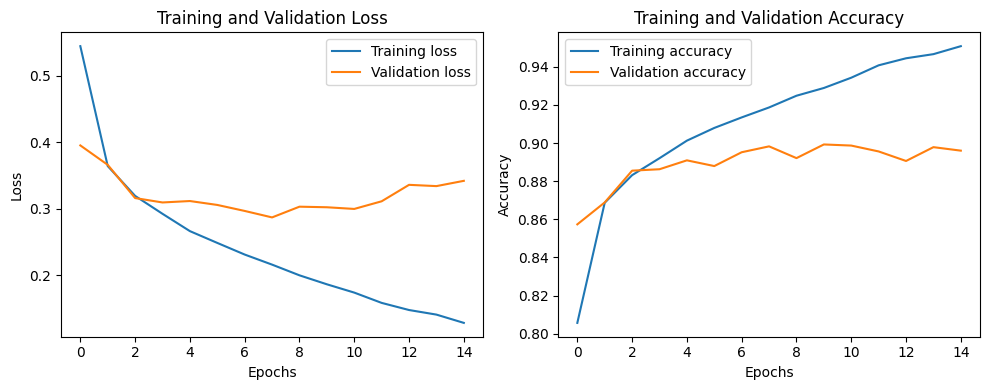

Test Accuracy of the model on the test images: 89.08%
Train Accuracy: 0.9508125
Validation Accuracy: 0.896
Model weights saved to lenet5_modified_weights.pth


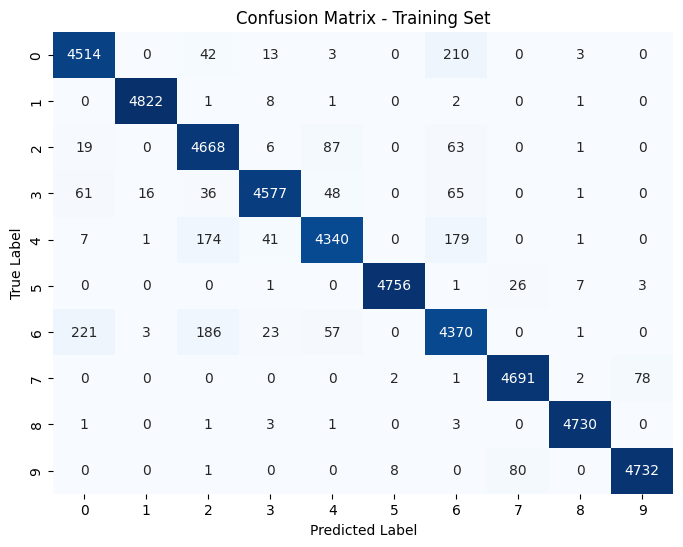

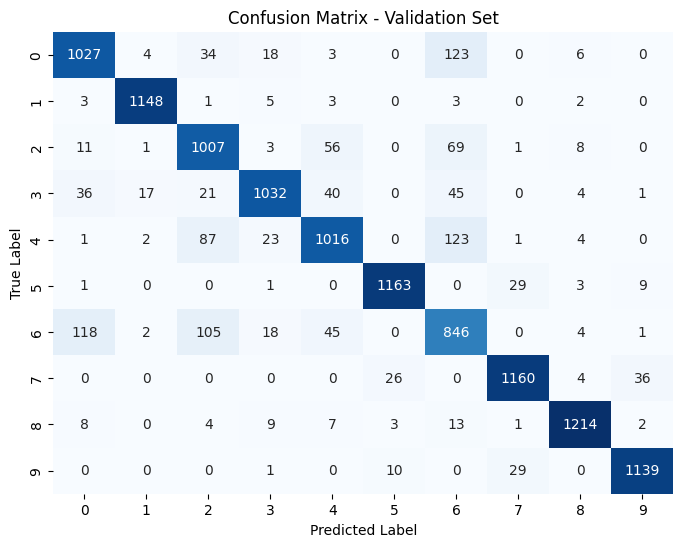

In [ ]:
####################################
#DEFAULT MODEL
####################################
model = LeNet5Modified()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
torch.save(model, 'lenet5_modified_model.pth')

Epoch 1/15.. Train loss: 0.481.. Train accuracy: 0.827.. Validation loss: 0.360.. Validation accuracy: 0.869
Epoch 2/15.. Train loss: 0.331.. Train accuracy: 0.879.. Validation loss: 0.328.. Validation accuracy: 0.881
Epoch 3/15.. Train loss: 0.286.. Train accuracy: 0.894.. Validation loss: 0.297.. Validation accuracy: 0.891
Epoch 4/15.. Train loss: 0.257.. Train accuracy: 0.905.. Validation loss: 0.278.. Validation accuracy: 0.897
Epoch 5/15.. Train loss: 0.231.. Train accuracy: 0.916.. Validation loss: 0.311.. Validation accuracy: 0.886
Epoch 6/15.. Train loss: 0.212.. Train accuracy: 0.921.. Validation loss: 0.272.. Validation accuracy: 0.901
Epoch 7/15.. Train loss: 0.195.. Train accuracy: 0.927.. Validation loss: 0.277.. Validation accuracy: 0.898
Epoch 8/15.. Train loss: 0.176.. Train accuracy: 0.934.. Validation loss: 0.293.. Validation accuracy: 0.899
Epoch 9/15.. Train loss: 0.162.. Train accuracy: 0.940.. Validation loss: 0.281.. Validation accuracy: 0.901
Epoch 10/15.. Train

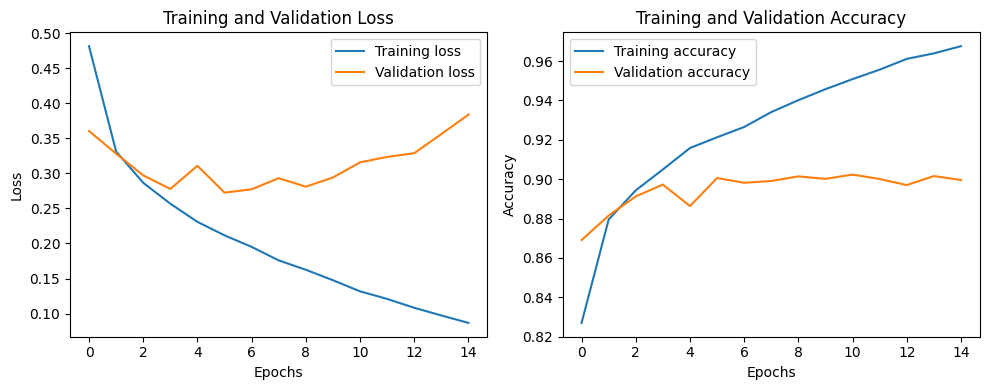

Test Accuracy of the model on the test images: 89.44%
Train Accuracy: 0.9675833333333334
Validation Accuracy: 0.8995833333333333


In [ ]:
####################################
# 3X3 KERNEL INSTEAD OF 5X5
####################################
class LeNet5_3x3(nn.Module):
    def __init__(self):
        super(LeNet5_3x3, self).__init__()
        # 3x3 kernels
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        # 3x3 kernels
        self.conv2 = nn.Conv2d(6, 16, 3)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self._initialize_weights()

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

model = LeNet5_3x3()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
torch.save(model, 'LeNet5_3x3_model.pth')

Epoch 1/15.. Train loss: 0.502.. Train accuracy: 0.821.. Validation loss: 0.350.. Validation accuracy: 0.874
Epoch 2/15.. Train loss: 0.339.. Train accuracy: 0.878.. Validation loss: 0.307.. Validation accuracy: 0.890
Epoch 3/15.. Train loss: 0.295.. Train accuracy: 0.893.. Validation loss: 0.308.. Validation accuracy: 0.890
Epoch 4/15.. Train loss: 0.263.. Train accuracy: 0.905.. Validation loss: 0.278.. Validation accuracy: 0.900
Epoch 5/15.. Train loss: 0.241.. Train accuracy: 0.911.. Validation loss: 0.262.. Validation accuracy: 0.907
Epoch 6/15.. Train loss: 0.222.. Train accuracy: 0.918.. Validation loss: 0.265.. Validation accuracy: 0.904
Epoch 7/15.. Train loss: 0.203.. Train accuracy: 0.923.. Validation loss: 0.259.. Validation accuracy: 0.908
Epoch 8/15.. Train loss: 0.187.. Train accuracy: 0.930.. Validation loss: 0.266.. Validation accuracy: 0.910
Epoch 9/15.. Train loss: 0.170.. Train accuracy: 0.936.. Validation loss: 0.265.. Validation accuracy: 0.908
Epoch 10/15.. Train

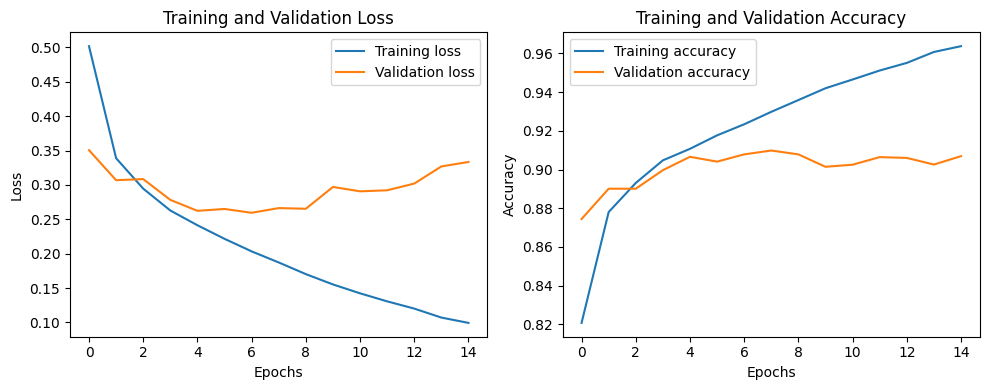

Test Accuracy of the model on the test images: 89.55%
Train Accuracy: 0.9637708333333334
Validation Accuracy: 0.9069166666666667
Model weights saved to LeNet5_leaky_relu_model.pth


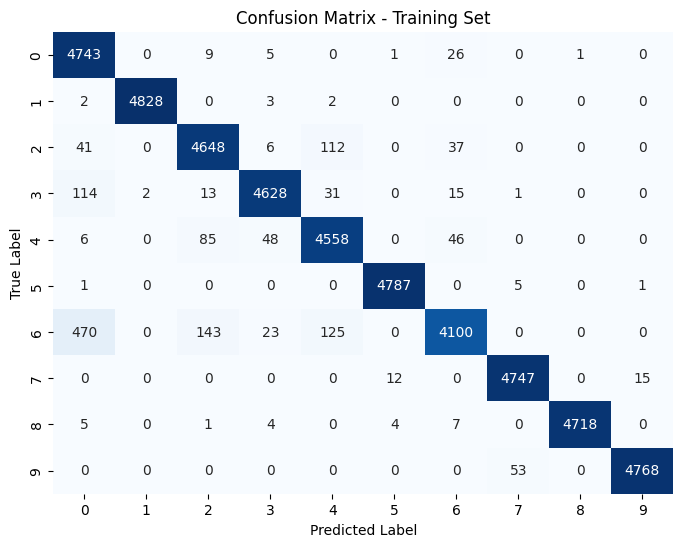

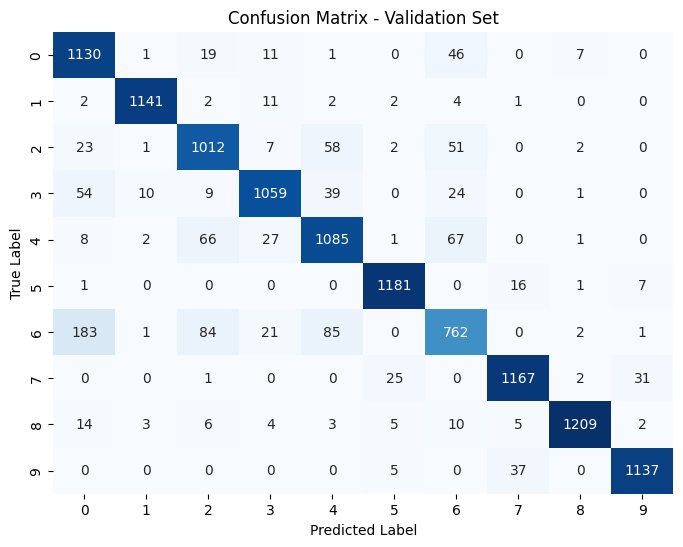

In [ ]:
####################################
#USING DIFFERENT ACTIVATION FUNCTION (LEAKY RELU) on 3x3 kernel
####################################
class LeNet5_ActivationVariant(nn.Module):
    def __init__(self):
        super(LeNet5_ActivationVariant, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


model = LeNet5_ActivationVariant()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
save_weights(model, trainloader, validationloader, 'LeNet5_leaky_relu_model.pth')



Epoch 1/15.. Train loss: 0.661.. Train accuracy: 0.762.. Validation loss: 0.382.. Validation accuracy: 0.858
Epoch 2/15.. Train loss: 0.411.. Train accuracy: 0.852.. Validation loss: 0.337.. Validation accuracy: 0.876
Epoch 3/15.. Train loss: 0.358.. Train accuracy: 0.873.. Validation loss: 0.307.. Validation accuracy: 0.888
Epoch 4/15.. Train loss: 0.329.. Train accuracy: 0.880.. Validation loss: 0.292.. Validation accuracy: 0.893
Epoch 5/15.. Train loss: 0.305.. Train accuracy: 0.889.. Validation loss: 0.286.. Validation accuracy: 0.895
Epoch 6/15.. Train loss: 0.287.. Train accuracy: 0.896.. Validation loss: 0.275.. Validation accuracy: 0.898
Epoch 7/15.. Train loss: 0.272.. Train accuracy: 0.898.. Validation loss: 0.276.. Validation accuracy: 0.899
Epoch 8/15.. Train loss: 0.259.. Train accuracy: 0.905.. Validation loss: 0.272.. Validation accuracy: 0.900
Epoch 9/15.. Train loss: 0.246.. Train accuracy: 0.908.. Validation loss: 0.277.. Validation accuracy: 0.901
Epoch 10/15.. Train

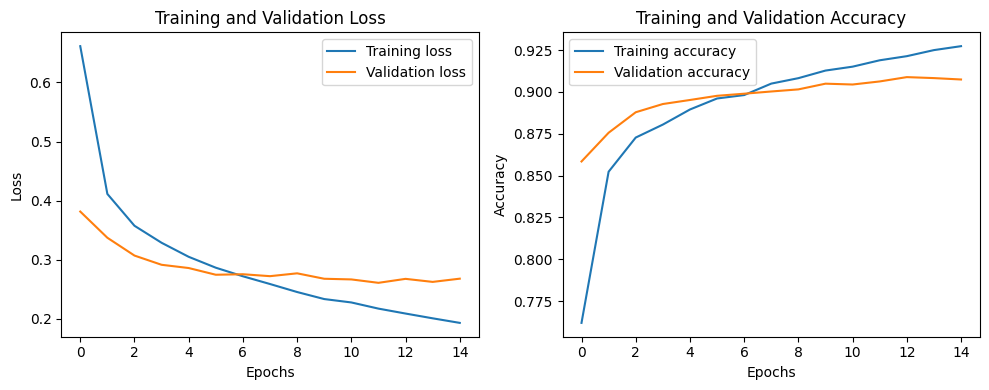

Test Accuracy of the model on the test images: 90.23%
Train Accuracy: 0.9273333333333333
Validation Accuracy: 0.9074166666666666
Model weights saved to LeNet5_Dropout_model.pth


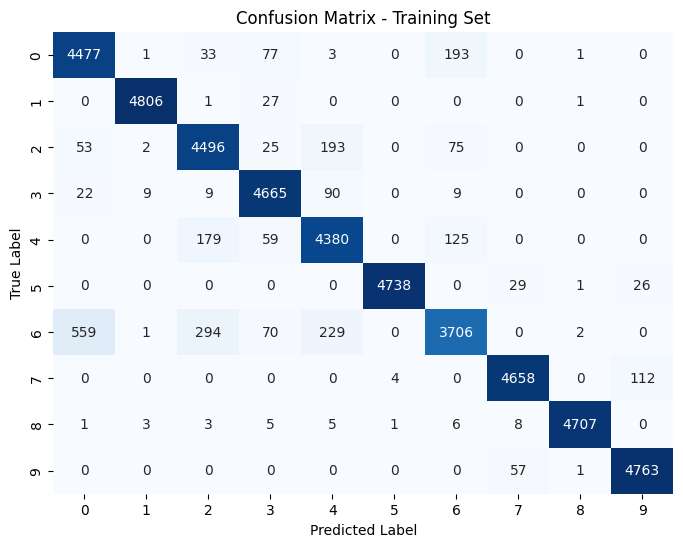

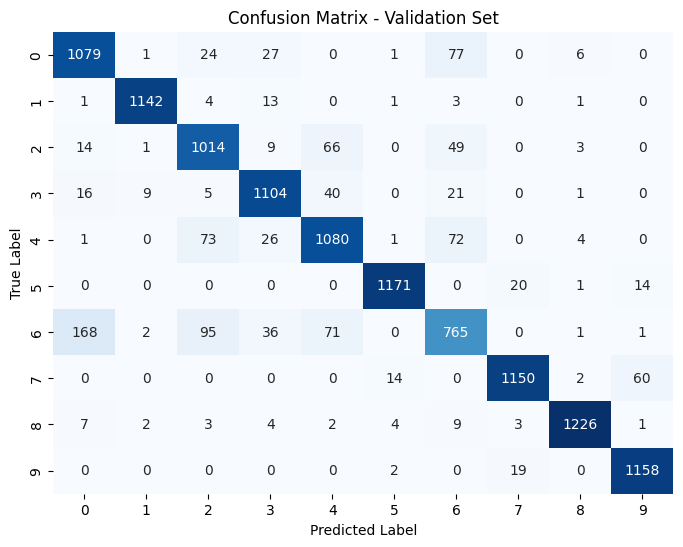

In [ ]:
####################################
#DROPOUT with(LEAKY RELU) on 3x3 kernel
####################################
class LeNet5_Dropout(nn.Module):
    def __init__(self):
        super(LeNet5_LR, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)  # Dropout with 25% probability

        self._initialize_weights()

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Model instantiation
model = LeNet5_Dropout()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
save_weights(model, trainloader, validationloader, 'LeNet5_Dropout_model.pth')


Epoch 1/15.. Train loss: 0.659.. Train accuracy: 0.760.. Validation loss: 0.409.. Validation accuracy: 0.851
Epoch 2/15.. Train loss: 0.421.. Train accuracy: 0.848.. Validation loss: 0.354.. Validation accuracy: 0.872
Epoch 3/15.. Train loss: 0.364.. Train accuracy: 0.870.. Validation loss: 0.329.. Validation accuracy: 0.877
Epoch 4/15.. Train loss: 0.335.. Train accuracy: 0.878.. Validation loss: 0.318.. Validation accuracy: 0.883
Epoch 5/15.. Train loss: 0.310.. Train accuracy: 0.888.. Validation loss: 0.304.. Validation accuracy: 0.891
Epoch 6/15.. Train loss: 0.292.. Train accuracy: 0.893.. Validation loss: 0.287.. Validation accuracy: 0.895
Epoch 7/15.. Train loss: 0.277.. Train accuracy: 0.899.. Validation loss: 0.286.. Validation accuracy: 0.892
Epoch 8/15.. Train loss: 0.267.. Train accuracy: 0.903.. Validation loss: 0.270.. Validation accuracy: 0.904
Epoch 9/15.. Train loss: 0.251.. Train accuracy: 0.908.. Validation loss: 0.257.. Validation accuracy: 0.906
Epoch 10/15.. Train

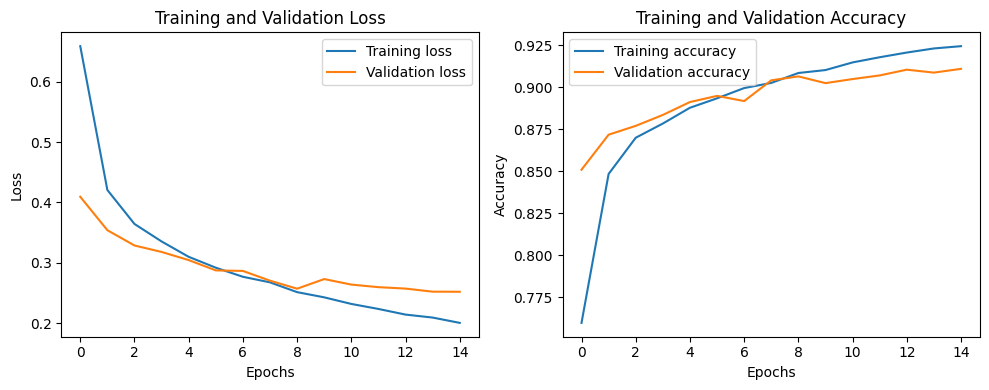

Test Accuracy of the model on the test images: 90.48%
Train Accuracy: 0.9243958333333333
Validation Accuracy: 0.9109166666666667
Model weights saved to LeNet5_Dropout_lr_model.pth


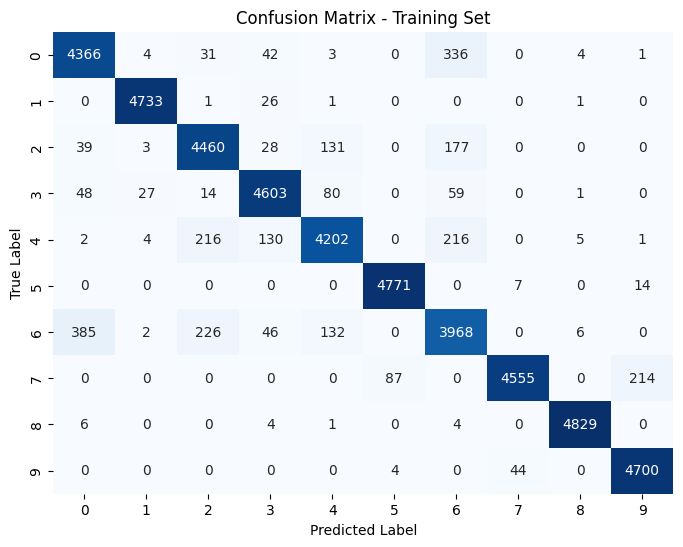

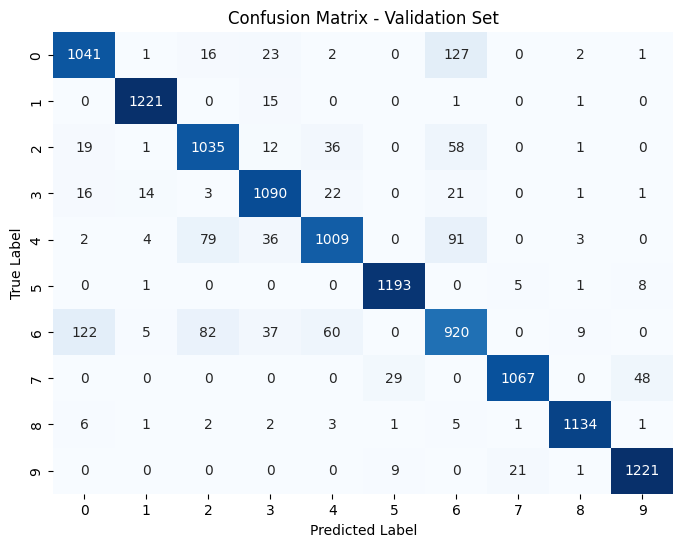

In [ ]:
####################################
#AVERAGE POOLING WITH DROPOUT with(LEAKY RELU) on 3x3 kernel
####################################
class LeNet5_AP(nn.Module):
    def __init__(self):
        super(LeNet5_AP, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)  # Dropout with 25% probability

        self._initialize_weights()

    def forward(self, x):
        # Use Average Pooling
        x = F.avg_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc3(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


model = LeNet5_AP()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
save_weights(model, trainloader, validationloader, 'LeNet5_Dropout_lr_model.pth')



In [ ]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)


trainloader = DataLoader(trainset, batch_size=64, shuffle=True)


print(f"Training Set: {len(trainset)} samples")

Training Set: 60000 samples


Epoch 1/15.. Train loss: 0.644.. Train accuracy: 0.766.. 
Epoch 2/15.. Train loss: 0.419.. Train accuracy: 0.849.. 
Epoch 3/15.. Train loss: 0.363.. Train accuracy: 0.869.. 
Epoch 4/15.. Train loss: 0.330.. Train accuracy: 0.881.. 
Epoch 5/15.. Train loss: 0.304.. Train accuracy: 0.890.. 
Epoch 6/15.. Train loss: 0.287.. Train accuracy: 0.896.. 
Epoch 7/15.. Train loss: 0.272.. Train accuracy: 0.902.. 
Epoch 8/15.. Train loss: 0.259.. Train accuracy: 0.907.. 
Epoch 9/15.. Train loss: 0.245.. Train accuracy: 0.911.. 
Epoch 10/15.. Train loss: 0.236.. Train accuracy: 0.913.. 
Epoch 11/15.. Train loss: 0.226.. Train accuracy: 0.918.. 
Epoch 12/15.. Train loss: 0.218.. Train accuracy: 0.920.. 
Epoch 13/15.. Train loss: 0.212.. Train accuracy: 0.923.. 
Epoch 14/15.. Train loss: 0.202.. Train accuracy: 0.926.. 
Epoch 15/15.. Train loss: 0.196.. Train accuracy: 0.928.. 


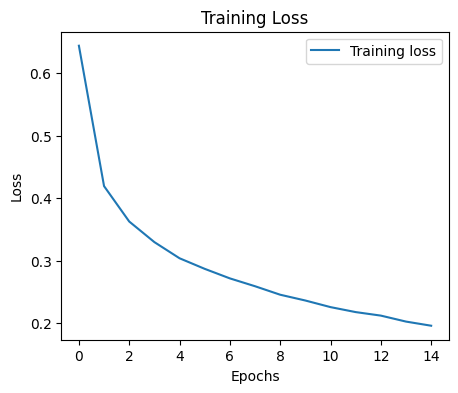

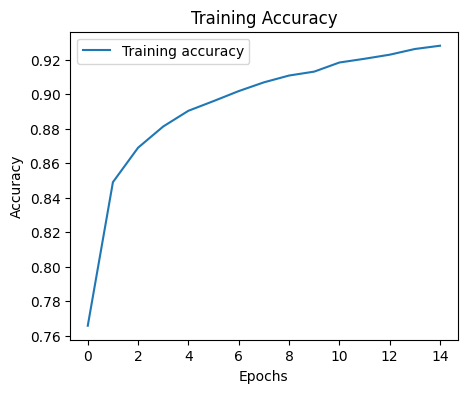

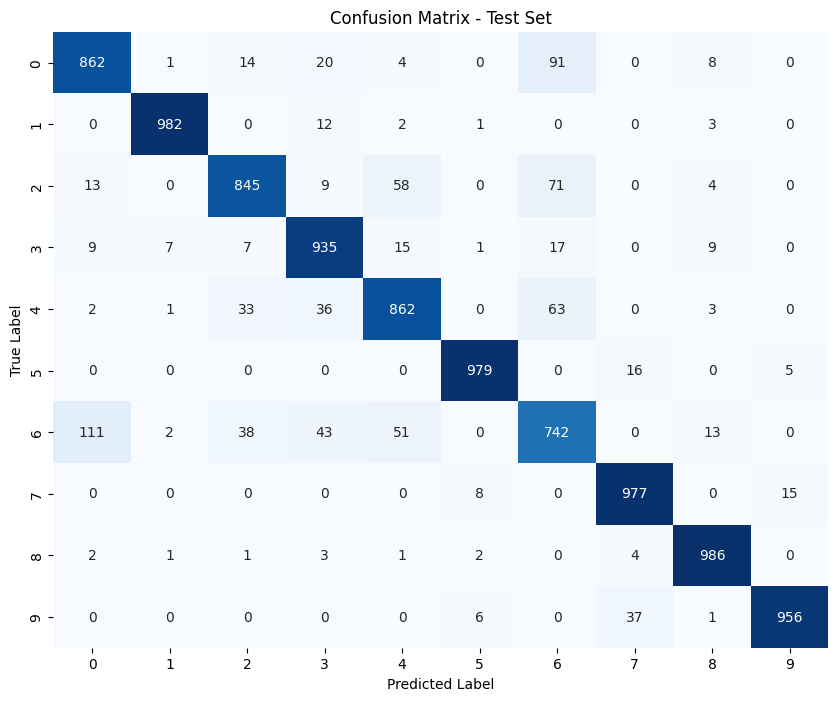

Test Accuracy of the model on the test images: 91.25999999999999%


In [ ]:
####################################
#TRAINNED ON TRAIN+VAL DATA USING DIFFERENT BEST MODEL
####################################
class LeNet5_AP(nn.Module):
    def __init__(self):
        super(LeNet5_AP, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)  # Dropout with 25% probability

        self._initialize_weights()

    def forward(self, x):
        x = F.avg_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc3(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def train_model(model, criterion, optimizer, trainloader, epochs=15):
    model.to(device)

    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        running_loss = 0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_losses[-1]:.3f}.. "
              f"Train accuracy: {train_accuracies[-1]:.3f}.. ")

    return train_losses, train_accuracies


def compute_confusion_matrix(model, dataloader, device):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def evaluate_and_plot(model, train_losses, train_accuracies, testloader):

    model.eval()

    plt.figure(figsize=(5, 4))
    plt.plot(train_losses, label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(train_accuracies, label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Testing the model for accuracy on the test set
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    # Save the model's weights
    torch.save(model, 'lenet5_VAL_TRAIN.pth')
    # print(f"Model weights saved to {save_path}")

    # Compute confusion matrix for the dataset
    cm = compute_confusion_matrix(model, testloader, device)

    # Plot confusion matrix
    plot_confusion_matrix(cm, title='Confusion Matrix - Test Set')

    test_accuracy = correct / total * 100
    print(f'Test Accuracy of the model on the test images: {test_accuracy}%')
    return test_accuracy

model = LeNet5_AP()

# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, train_accuracies = train_model(model, criterion, optimizer, trainloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, train_accuracies, testloader)


In [ ]:
#normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

print(f"Training Set: {len(trainset)} samples")


Training Set: 60000 samples


In [ ]:
def train_model_kfold(model_class, criterion, optimizer_class, dataset, epochs=10, k_folds=10, lr=0.001):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_train_accuracies = []
    fold_validation_accuracies = []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(dataset)))):
        print(f'FOLD {fold}')
        print('--------------------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=validation_subsampler)

        model = model_class()
        optimizer = optimizer_class(model.parameters(), lr=lr)

        best_train_accuracy = 0
        best_validation_accuracy = 0

        for epoch in range(epochs):
            model.train()
            correct = total = 0
            for images, labels in trainloader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = 100 * correct / total

            model.eval()
            correct = total = 0
            with torch.no_grad():
                for images, labels in validationloader:
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            validation_accuracy = 100 * correct / total

            if train_accuracy > best_train_accuracy:
                best_train_accuracy = train_accuracy
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy

        fold_train_accuracies.append(best_train_accuracy)
        fold_validation_accuracies.append(best_validation_accuracy)
        print(f"Best Train Accuracy for Fold {fold}: {best_train_accuracy:.2f}%")
        print(f"Best Validation Accuracy for Fold {fold}: {best_validation_accuracy:.2f}%")

    avg_train_accuracy = sum(fold_train_accuracies) / k_folds
    avg_validation_accuracy = sum(fold_validation_accuracies) / k_folds
    print(f"\nAverage Train Accuracy: {avg_train_accuracy:.2f}%")
    print(f"Average Validation Accuracy: {avg_validation_accuracy:.2f}%")

    return avg_train_accuracy, avg_validation_accuracy

avg_train_accuracy, avg_validation_accuracy = train_model_kfold(LeNet5Modified, nn.CrossEntropyLoss(), optim.Adam, trainset, epochs=15, k_folds=5, lr=0.001)

FOLD 0
--------------------------------
Best Train Accuracy for Fold 0: 95.42%
Best Validation Accuracy for Fold 0: 90.63%
FOLD 1
--------------------------------
Best Train Accuracy for Fold 1: 95.69%
Best Validation Accuracy for Fold 1: 90.03%
FOLD 2
--------------------------------
Best Train Accuracy for Fold 2: 95.22%
Best Validation Accuracy for Fold 2: 90.32%
FOLD 3
--------------------------------
Best Train Accuracy for Fold 3: 95.35%
Best Validation Accuracy for Fold 3: 90.20%
FOLD 4
--------------------------------
Best Train Accuracy for Fold 4: 94.87%
Best Validation Accuracy for Fold 4: 89.78%

Average Train Accuracy: 95.31%
Average Validation Accuracy: 90.19%


In [12]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# # transforms for the training data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(20),  # Randomly rotate images by 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly alter the color properties
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),  # Gaussian blur
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# transform for the validation data (without augmentation)
validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=train_transforms)
validationset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=validation_transforms)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validationloader = DataLoader(validationset, batch_size=64, shuffle=True)

Augmented Training Images:


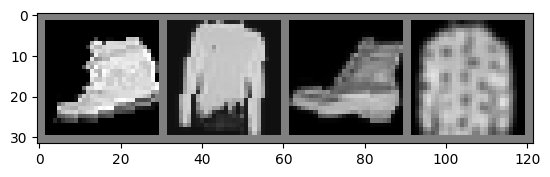

Validation Images:


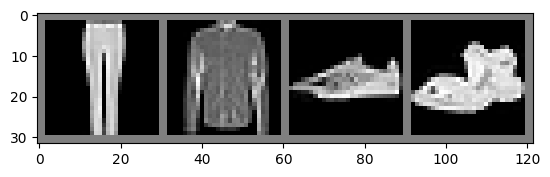

Test Images:


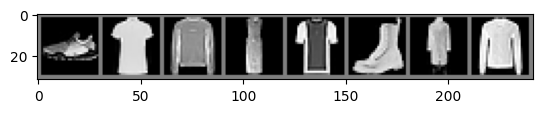

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


print("Augmented Training Images:")
imshow(torchvision.utils.make_grid(images[:4]))


dataiter = iter(validationloader)
images, labels = next(dataiter)


print("Validation Images:")
imshow(torchvision.utils.make_grid(images[:4]))

dataiter = iter(testloader)
images, labels = next(dataiter)


print("Test Images:")
imshow(torchvision.utils.make_grid(images[:8]))

Epoch 1/15.. Train loss: 0.797.. Train accuracy: 0.707.. Validation loss: 0.515.. Validation accuracy: 0.805
Epoch 2/15.. Train loss: 0.548.. Train accuracy: 0.798.. Validation loss: 0.443.. Validation accuracy: 0.838
Epoch 3/15.. Train loss: 0.492.. Train accuracy: 0.819.. Validation loss: 0.407.. Validation accuracy: 0.854
Epoch 4/15.. Train loss: 0.456.. Train accuracy: 0.833.. Validation loss: 0.400.. Validation accuracy: 0.851
Epoch 5/15.. Train loss: 0.429.. Train accuracy: 0.843.. Validation loss: 0.358.. Validation accuracy: 0.871
Epoch 6/15.. Train loss: 0.408.. Train accuracy: 0.852.. Validation loss: 0.355.. Validation accuracy: 0.870
Epoch 7/15.. Train loss: 0.398.. Train accuracy: 0.855.. Validation loss: 0.342.. Validation accuracy: 0.878
Epoch 8/15.. Train loss: 0.383.. Train accuracy: 0.859.. Validation loss: 0.335.. Validation accuracy: 0.879
Epoch 9/15.. Train loss: 0.376.. Train accuracy: 0.863.. Validation loss: 0.339.. Validation accuracy: 0.876
Epoch 10/15.. Train

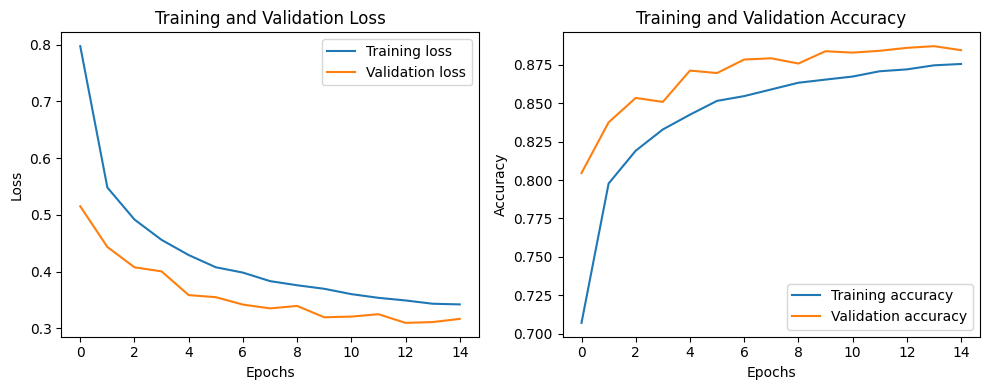

Test Accuracy of the model on the test images: 88.46000000000001%
Train Accuracy: 0.8756166666666667
Validation Accuracy: 0.8846
Model weights saved to LeNet5_DATA_AUG.pth


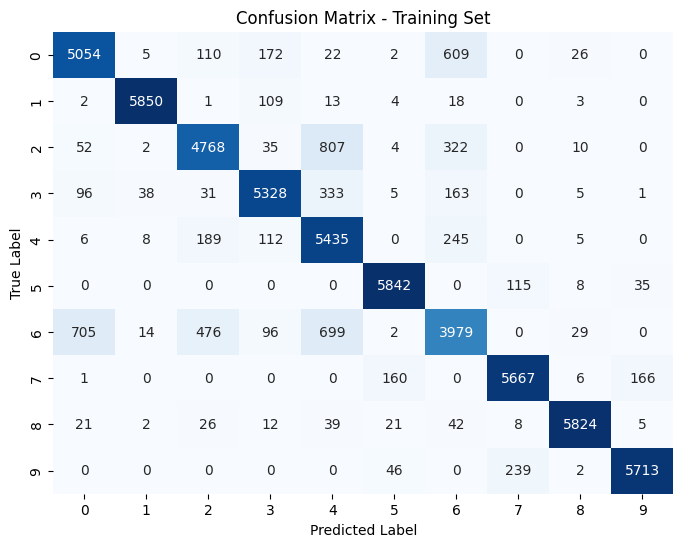

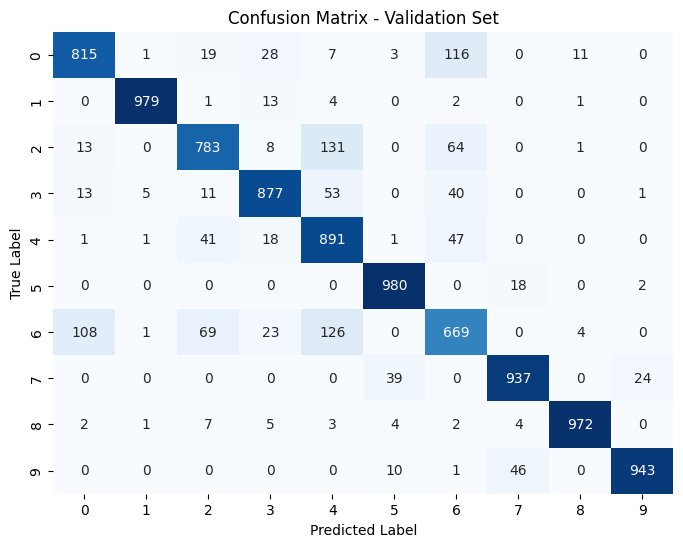

In [14]:
####################################
# DATA AUGMENTATION WITH THE BEST MODEL
####################################
class LeNet5_AP(nn.Module):
    def __init__(self):
        super(LeNet5_AP, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)  # Dropout with 25% probability

        self._initialize_weights()

    def forward(self, x):
        # Use Average Pooling
        x = F.avg_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.leaky_relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc3(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


model = LeNet5_AP()
model.to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model, criterion, optimizer, trainloader, validationloader, epochs=15)
test_accuracy = evaluate_and_plot(model, train_losses, validation_losses, train_accuracies, validation_accuracies, testloader)
print("Train Accuracy:",train_accuracies[-1])
print("Validation Accuracy:",validation_accuracies[-1])
save_weights(model, trainloader, validationloader, 'LeNet5_DATA_AUG.pth')


In [ ]:
class LeNet5Modified(nn.Module):
    def __init__(self):
        super(LeNet5Modified, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def get_embeddings(self, x):
            # Extract embeddings from the fc2 layer
            x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
            x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


model = LeNet5Modified()

# Cross entropy loss
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = []
        labels = []

        for images, target in dataloader:
            embed = model.get_embeddings(images)
            embeddings.append(embed)
            labels.append(target)

        embeddings = torch.cat(embeddings).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()

    return embeddings, labels

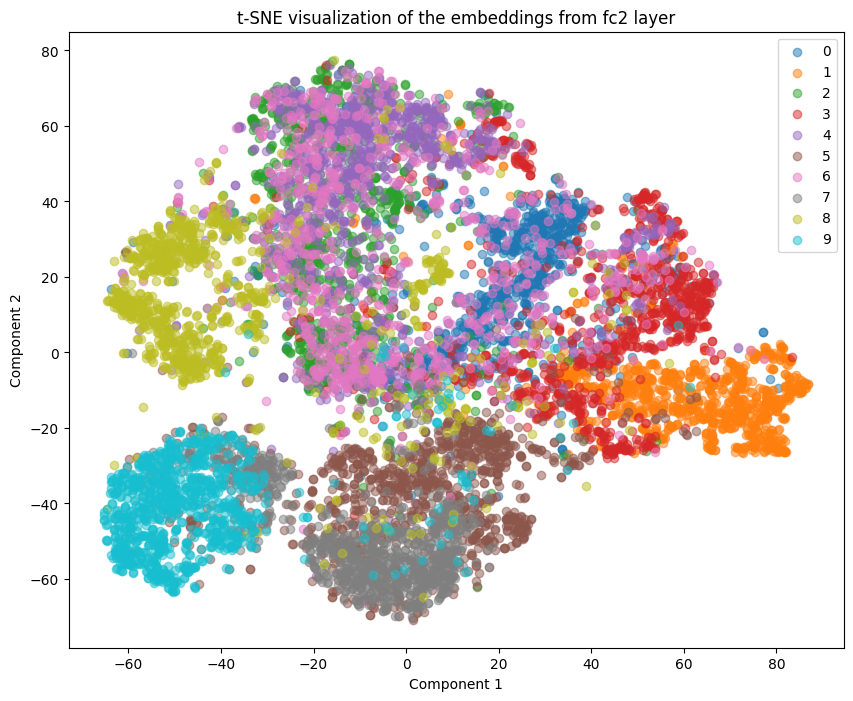

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings and labels from the test set
embeddings, labels = extract_embeddings(testloader, model)

# Apply t-SNE to reduce the dimensionality of embeddings to 2D
tsne = TSNE(n_components=2, random_state=33)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualization
plt.figure(figsize=(10, 8))
for i in range(10):
    idxs = labels == i
    plt.scatter(reduced_embeddings[idxs, 0], reduced_embeddings[idxs, 1], label=str(i), alpha=0.5)
plt.legend()
plt.title('t-SNE visualization of the embeddings from fc2 layer')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()